In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, r2_score, mean_absolute_error, classification_report, plot_confusion_matrix, accuracy_score
from scipy.stats import reciprocal, randint
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

# Exploración

In [2]:
df = pd.read_csv('winequality-red.csv', sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df.quality.value_counts(sort=False)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

Como el desbalanceo de clases es fuerte, se seleccionara la opción `balanced` en el hiperparámetro `class_weight` con el fin contrarestrar el desbalanceo. 
Además se entrenara con distinto número de clases, con el fin de evaluar el desempeño en cada una, porque al tener seis clases, de las cuales algunas tienen muy pocos registros, es bueno agrupar las clases minoritarias en una sola.
Para probar los diferentes modelos el dataset se separara en tres partes: datos de entrenamiento 60%, datos de validación 20%, datos de prueba 20%.

Se separan los datos en variables independientes `X` y variable dependiente `y`.
Se estandarizan las variables independientes

In [4]:
X = df.drop(columns='quality')
sc = StandardScaler()
X = sc.fit_transform(X)
y = df.quality

Se definen agrupaciones diferentes para la variable de salida `y`.

In [5]:
y_list = [['Calidad con todos los valores', y],
          ['Calidad con 2 clases', pd.cut(y, bins=[0, 5.5, 10], labels=[0, 1])],
          ['Calidad con 3 clases uniforme', pd.cut(y, bins=[0, 4.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 3 clases no uniforme', pd.cut(y, bins=[0, 5.5, 6.5, 10], labels=[0, 1, 2])],
          ['Calidad con 4 clases', pd.cut(y, bins=[0, 4.5, 5.5, 6.5, 10], labels=[0, 1, 2, 3])]
         ]

Función para determinar y graficar las variables independientes mas importantes

In [6]:
def plot_feature_importances(clf, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    clf.fit(X_train, y_train)
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

# Modelos simples
Primero se van a entrenar modelos no ensamblados para mirar sus rendimientos individuales, más adelante se validara el rendimiento de los modelos de ensamble. En todos los entrenamientos se realiza `Cross Validation` para hallar los mejores hiperparámetros para cada modelo.

## Regresión Logística

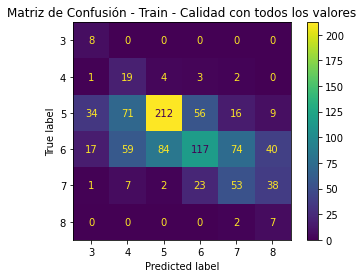

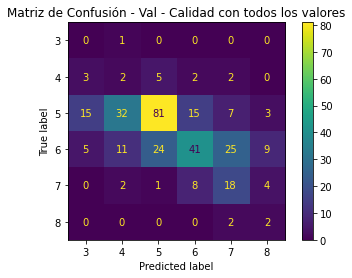

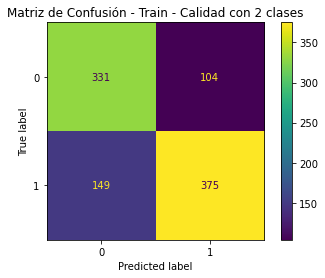

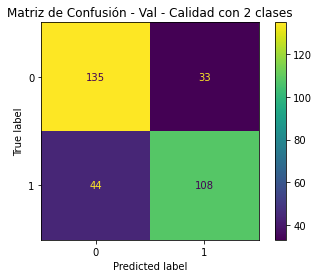

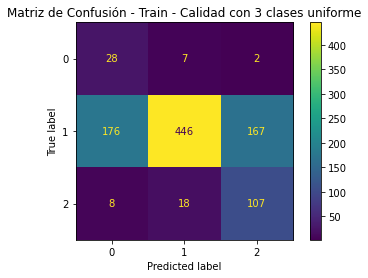

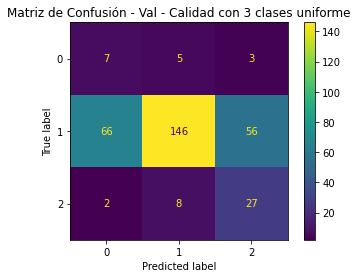

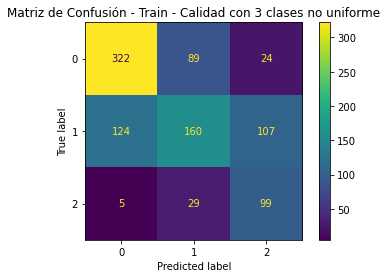

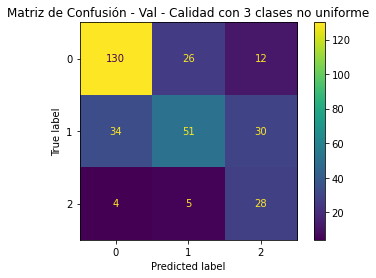

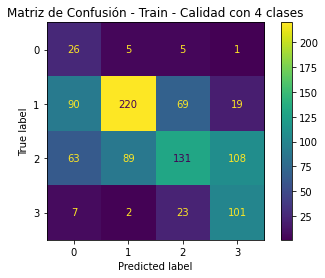

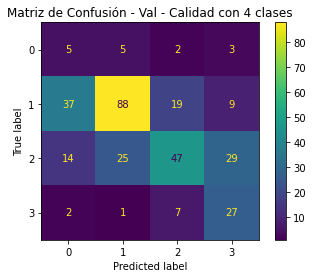

Wall time: 3min


In [7]:
%%time
list_lr = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    log_est = LogisticRegression(class_weight='balanced', 
                                                multi_class='multinomial',
                                                solver='newton-cg',
                                                fit_intercept=True, 
                                                penalty='l2',
                                                max_iter=500)

    dists = {'C': reciprocal(1e-4, 1e4)}

    lr = RandomizedSearchCV(log_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    lr.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(lr, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(lr, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_lr.append([Y[0], 
                   f1_score(y_train, lr.predict(X_train), average='macro'),
                   f1_score(y_val, lr.predict(X_val), average='macro'),
                   accuracy_score(y_train, lr.predict(X_train)),
                   accuracy_score(y_val, lr.predict(X_val)),
                   f1_score(y_train, lr.predict(X_train), average=None),
                   f1_score(y_val, lr.predict(X_val), average=None)]
                  )

In [8]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:,.4f}'.format
labels_metrics = ['Variables', 'F1 Score Train', 'F1 Score Val','Accuracy Train','Accuracy Test','F1 Train Scores for each class', 'F1 Validation Scores for each class']
df_metrics_lr = pd.DataFrame(list_lr, columns=labels_metrics)
df_metrics_lr

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,0.3278,0.2878,0.4338,0.4500,"[0.23188405797101452, 0.20540540540540542, 0.6057142857142858, 0.39661016949152544, 0.3911439114...","[0.0, 0.06451612903225806, 0.6136363636363636, 0.4530386740331491, 0.41379310344827586, 0.181818..."
1,Calidad con 2 clases,0.7356,0.7576,0.7362,0.7594,"[0.7234972677595628, 0.7477567298105683]","[0.7780979827089337, 0.7372013651877133]"
2,Calidad con 3 clases uniforme,0.4854,0.4261,0.6058,0.5625,"[0.2248995983935743, 0.707936507936508, 0.5232273838630807]","[0.15555555555555553, 0.6838407494145199, 0.43902439024390244]"
3,Calidad con 3 clases no uniforme,0.5835,0.6050,0.6058,0.6531,"[0.7268623024830699, 0.47832585949177875, 0.5454545454545455]","[0.7738095238095238, 0.5177664974619289, 0.5233644859813084]"
4,Calidad con 4 clases,0.4577,0.4483,0.4984,0.5219,"[0.23318385650224216, 0.6162464985994397, 0.42326332794830374, 0.5580110497237568]","[0.136986301369863, 0.6470588235294117, 0.49473684210526314, 0.5142857142857142]"


## Máquina de Soporte Vecotrial (SVM)

{'C': 52.97659425790558, 'gamma': 0.01951818446375059}


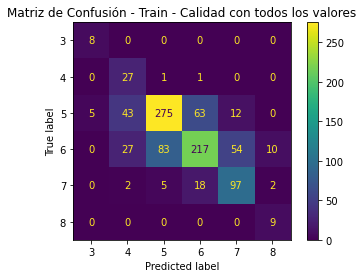

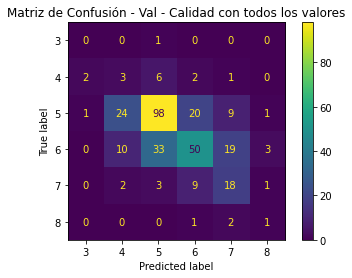

{'C': 1.9382492354118692, 'gamma': 0.154544498421539}


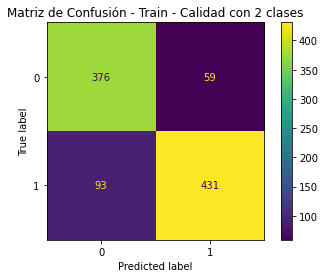

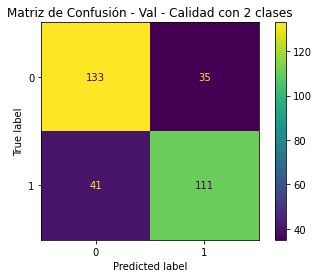

{'C': 1.2827179791833168, 'gamma': 0.14491911806280097}


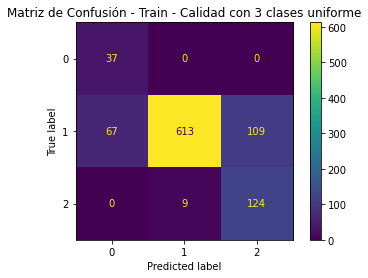

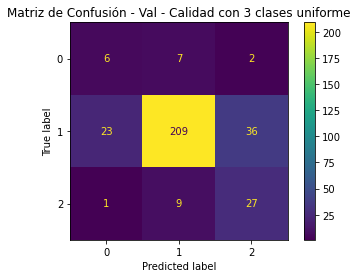

{'C': 2.823137458497318, 'gamma': 0.12853550433904812}


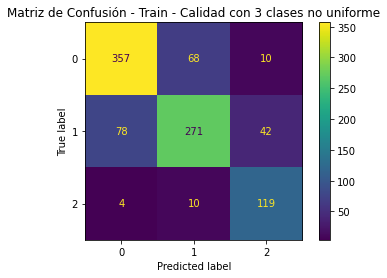

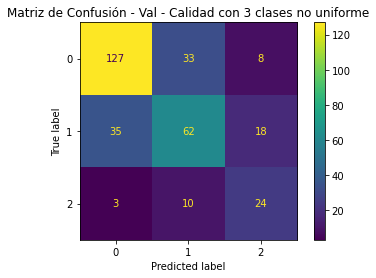

{'C': 20.223588500849882, 'gamma': 0.042301020627690596}


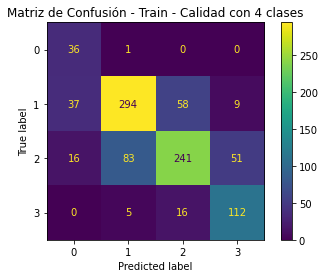

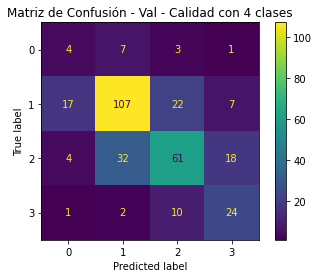

Wall time: 7min 8s


In [9]:
%%time
list_svm = []
best_params_svm = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_est = SVC(kernel='rbf', class_weight='balanced')

    dists = {'gamma':reciprocal(0.01, 100),'C': reciprocal(1e-4, 1e4)}

    svm = RandomizedSearchCV(svm_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    svm.fit(X_train, y_train)
    print(svm.best_params_)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm.append([Y[0], 
                   f1_score(y_train, svm.predict(X_train), average='macro'),
                   f1_score(y_val, svm.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm.predict(X_train)),
                   accuracy_score(y_val, svm.predict(X_val)),
                   f1_score(y_train, svm.predict(X_train), average=None),
                   f1_score(y_val, svm.predict(X_val), average=None)]
                   )
    best_params_svm.append([Y[0],
                           svm.best_params_['C'],
                           svm.best_params_['gamma'] 
                           ])

In [10]:
df_metrics_svm = pd.DataFrame(list_svm, columns=labels_metrics)
df_metrics_svm

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,0.6351,0.3211,0.6601,0.5312,"[0.761904761904762, 0.42187499999999994, 0.7217847769028871, 0.6289855072463768, 0.6759581881533...","[0.0, 0.11320754716981134, 0.6666666666666667, 0.5076142131979695, 0.43902439024390244, 0.2]"
1,Calidad con 2 clases,0.8410,0.7614,0.8415,0.7625,"[0.8318584070796461, 0.8500986193293886]","[0.7777777777777778, 0.7449664429530201]"
2,Calidad con 3 clases uniforme,0.6904,0.5480,0.8071,0.7562,"[0.524822695035461, 0.8688873139617292, 0.6775956284153006]","[0.26666666666666666, 0.8478701825557808, 0.5294117647058824]"
3,Calidad con 3 clases no uniforme,0.7774,0.6260,0.7789,0.6656,"[0.8169336384439359, 0.7324324324324325, 0.7828947368421054]","[0.7627627627627629, 0.5636363636363636, 0.5517241379310345]"
4,Calidad con 4 clases,0.6854,0.5090,0.7122,0.6125,"[0.5714285714285715, 0.7528809218950064, 0.6827195467422096, 0.7344262295081968]","[0.1951219512195122, 0.7109634551495018, 0.5781990521327015, 0.5517241379310345]"


## Árbol de Decisión

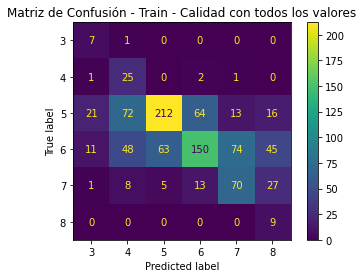

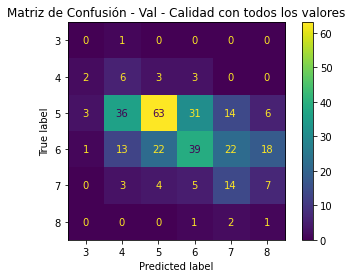

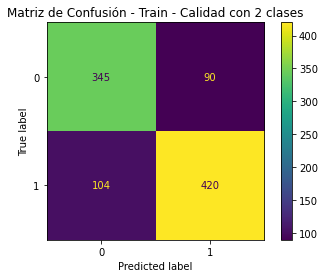

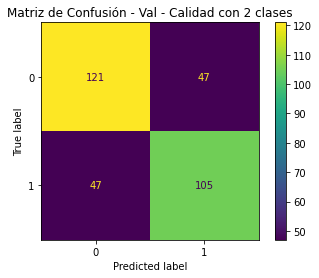

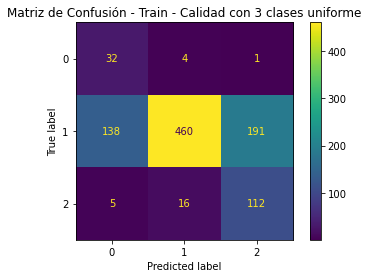

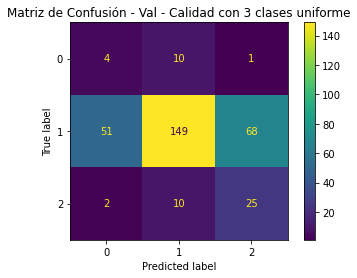

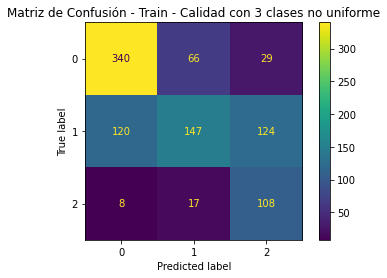

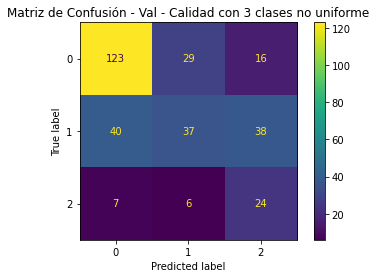

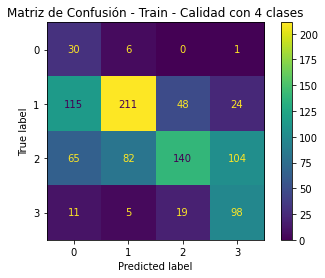

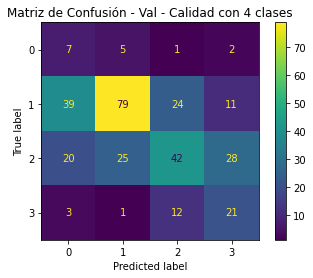

Wall time: 40 s


In [11]:
%%time
list_tree = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    tree_est = DecisionTreeClassifier(class_weight='balanced')

    dists = {'max_depth':range(2, 100),'min_samples_leaf': range(10, 1000)}

    tree = RandomizedSearchCV(tree_est, param_distributions = dists, n_iter=200, scoring='f1_macro')

    tree.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(tree, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(tree, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_tree.append([Y[0], 
                   f1_score(y_train, tree.predict(X_train), average='macro'),
                   f1_score(y_val, tree.predict(X_val), average='macro'),
                   accuracy_score(y_train, tree.predict(X_train)),
                   accuracy_score(y_val, tree.predict(X_val)),
                   f1_score(y_train, tree.predict(X_train), average=None),
                   f1_score(y_val, tree.predict(X_val), average=None)]
                   )

In [12]:
df_metrics_tree = pd.DataFrame(list_tree, columns=labels_metrics)
df_metrics_tree

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,0.3891,0.2443,0.4932,0.3844,"[0.28571428571428575, 0.273224043715847, 0.6253687315634219, 0.4838709677419355, 0.4964539007092...","[0.0, 0.16438356164383564, 0.5142857142857142, 0.4020618556701031, 0.32941176470588235, 0.055555..."
1,Calidad con 2 clases,0.7965,0.7055,0.7977,0.7063,"[0.7805429864253394, 0.8123791102514506]","[0.7202380952380952, 0.6907894736842105]"
2,Calidad con 3 clases uniforme,0.5132,0.3916,0.6298,0.5563,"[0.3018867924528302, 0.7249802994483846, 0.5125858123569794]","[0.11111111111111112, 0.6819221967963387, 0.38167938931297707]"
3,Calidad con 3 clases no uniforme,0.5916,0.5136,0.6204,0.5750,"[0.7530454042081949, 0.4734299516908212, 0.5482233502538072]","[0.727810650887574, 0.3957219251336898, 0.41739130434782606]"
4,Calidad con 4 clases,0.4616,0.4062,0.4995,0.4656,"[0.23255813953488372, 0.6011396011396011, 0.4682274247491639, 0.5444444444444445]","[0.16666666666666669, 0.6007604562737643, 0.4329896907216495, 0.42424242424242425]"


# Métodos de Ensamble

## Random Forest

{'n_estimators': 77, 'min_samples_leaf': 10, 'max_depth': 50}


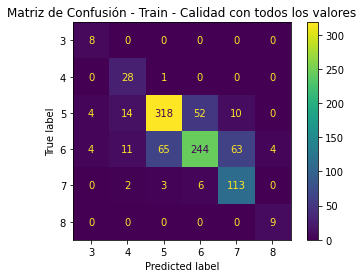

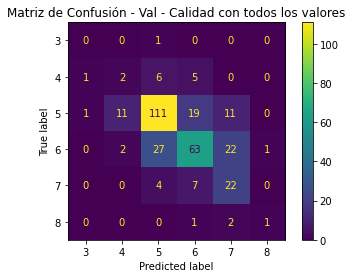

{'n_estimators': 71, 'min_samples_leaf': 2, 'max_depth': 50}


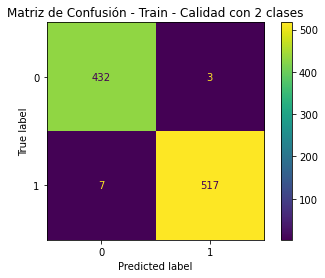

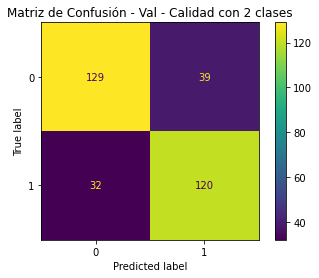

{'n_estimators': 39, 'min_samples_leaf': 13, 'max_depth': 50}


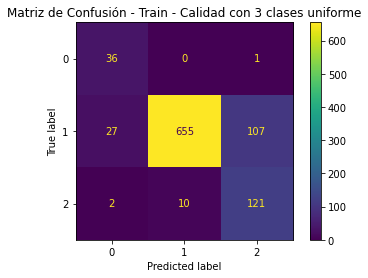

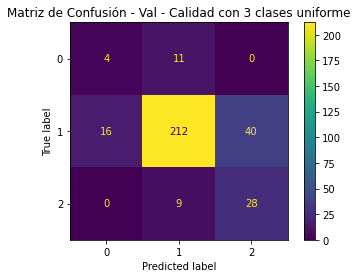

{'n_estimators': 39, 'min_samples_leaf': 4, 'max_depth': 50}


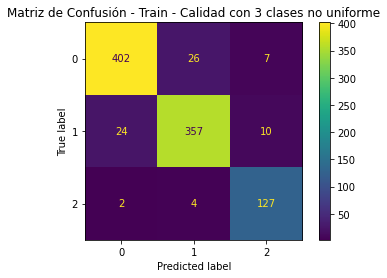

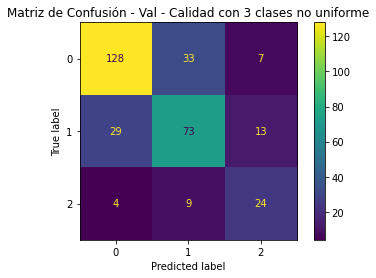

{'n_estimators': 61, 'min_samples_leaf': 12, 'max_depth': 50}


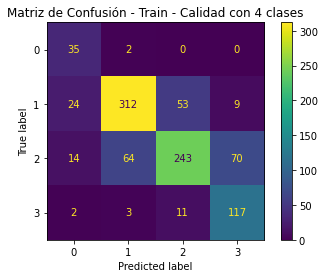

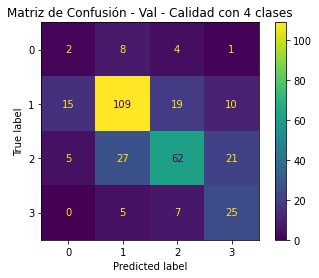

Wall time: 9min 8s


In [29]:
%%time
list_forest = []
best_params_forest = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    forest_est = RandomForestClassifier(class_weight='balanced')

    dists = {'n_estimators':range(20, 100), 'max_depth':(2, 50), 'min_samples_leaf':range(2, 50)}
    
    forest = RandomizedSearchCV(forest_est, param_distributions = dists, n_iter=100, scoring='f1_macro')

    forest.fit(X_train, y_train)
    print(forest.best_params_)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(forest, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(forest, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_forest.append([Y[0], 
                   f1_score(y_train, forest.predict(X_train), average='macro'),
                   f1_score(y_val, forest.predict(X_val), average='macro'),
                   accuracy_score(y_train, forest.predict(X_train)),
                   accuracy_score(y_val, forest.predict(X_val)),
                   f1_score(y_train, forest.predict(X_train), average=None),
                   f1_score(y_val, forest.predict(X_val), average=None)]
                   )
    best_params_forest.append([Y[0],
                           forest.best_params_['max_depth'],
                           forest.best_params_['min_samples_leaf'],
                           forest.best_params_['n_estimators']
                           ])

In [30]:
df_metrics_forest = pd.DataFrame(list_forest, columns=labels_metrics)
df_metrics_forest

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,0.7325,0.3825,0.7508,0.6219,"[0.6666666666666666, 0.6666666666666667, 0.8101910828025477, 0.7041847041847042, 0.7290322580645...","[0.0, 0.1379310344827586, 0.7350993377483444, 0.6, 0.4888888888888889, 0.3333333333333333]"
1,Calidad con 2 clases,0.9895,0.7779,0.9896,0.7781,"[0.9885583524027459, 0.9904214559386972]","[0.78419452887538, 0.7717041800643087]"
2,Calidad con 3 clases uniforme,0.7585,0.5366,0.8467,0.7625,"[0.7058823529411765, 0.9009628610729022, 0.6685082872928176]","[0.2285714285714286, 0.848, 0.5333333333333332]"
3,Calidad con 3 clases no uniforme,0.9221,0.6685,0.9239,0.7031,"[0.9316338354577057, 0.9177377892030848, 0.9169675090252708]","[0.7781155015197568, 0.6347826086956522, 0.5925925925925926]"
4,Calidad con 4 clases,0.7084,0.4902,0.7372,0.6188,"[0.625, 0.8010269576379975, 0.6962750716332379, 0.7112462006079027]","[0.10810810810810811, 0.7218543046357616, 0.5990338164251208, 0.5319148936170213]"


## Bagging de SVM

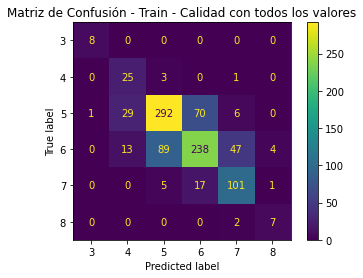

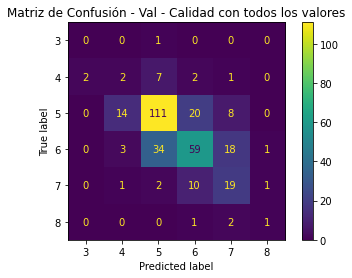

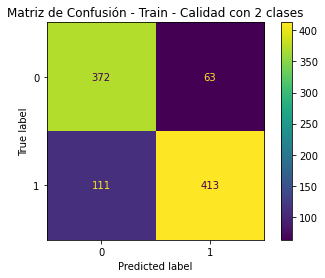

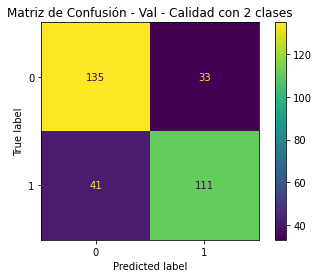

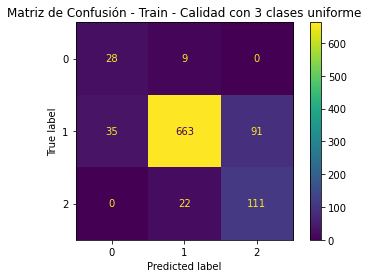

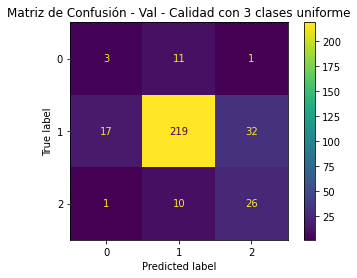

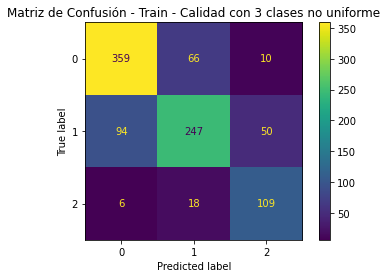

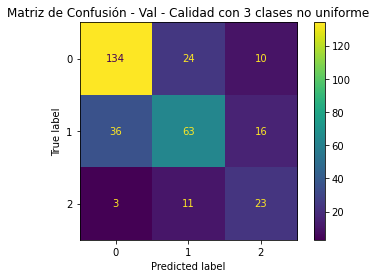

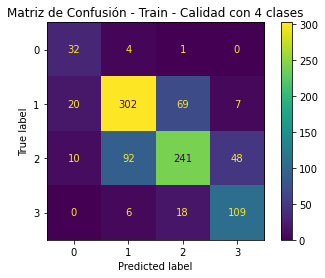

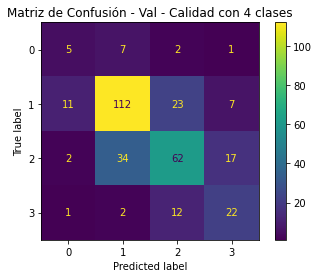

Wall time: 1h 12min 17s


In [15]:
%%time
list_svm_bag = []
best_params_bag = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    svm_bag_est = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=10, gamma=0.05, class_weight='balanced'), max_samples=2/3)

    dists = {'n_estimators':range(20, 100)}
    
    svm_bag = GridSearchCV(svm_bag_est, param_grid = dists, scoring='f1_macro')

    svm_bag.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(svm_bag, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(svm_bag, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_svm_bag.append([Y[0], 
                   f1_score(y_train, svm_bag.predict(X_train), average='macro'),
                   f1_score(y_val, svm_bag.predict(X_val), average='macro'),
                   accuracy_score(y_train, svm_bag.predict(X_train)),
                   accuracy_score(y_val, svm_bag.predict(X_val)),
                   f1_score(y_train, svm_bag.predict(X_train), average=None),
                   f1_score(y_val, svm_bag.predict(X_val), average=None)]
                   )
    best_params_bag.append([Y[0],
                           svm_bag.best_params_['n_estimators']])

In [16]:
df_metrics_svm_bag = pd.DataFrame(list_svm_bag, columns=labels_metrics)
df_metrics_svm_bag

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,0.7091,0.3606,0.6997,0.6000,"[0.9411764705882353, 0.5208333333333334, 0.7420584498094028, 0.664804469273743, 0.71886120996441...","[0.0, 0.11764705882352941, 0.7207792207792207, 0.5700483091787439, 0.4691358024691358, 0.2857142..."
1,Calidad con 2 clases,0.8182,0.7674,0.8186,0.7688,"[0.8104575163398694, 0.826]","[0.7848837209302326, 0.75]"
2,Calidad con 3 clases uniforme,0.7056,0.5235,0.8363,0.7750,"[0.56, 0.8941335131490222, 0.6626865671641791]","[0.16666666666666666, 0.8622047244094487, 0.5416666666666666]"
3,Calidad con 3 clases no uniforme,0.7364,0.6375,0.7456,0.6875,"[0.803131991051454, 0.6842105263157895, 0.7218543046357616]","[0.7859237536656892, 0.5915492957746479, 0.5348837209302325]"
4,Calidad con 4 clases,0.7008,0.5312,0.7132,0.6281,"[0.6464646464646465, 0.7531172069825436, 0.6694444444444443, 0.7340067340067341]","[0.29411764705882354, 0.7272727272727273, 0.5794392523364487, 0.5238095238095238]"


## Ada Boost

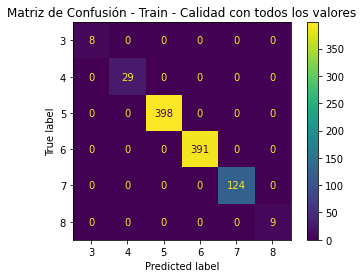

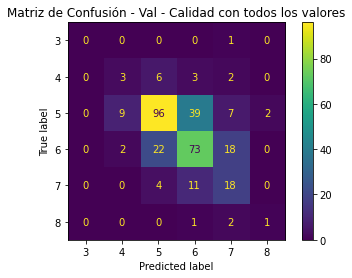

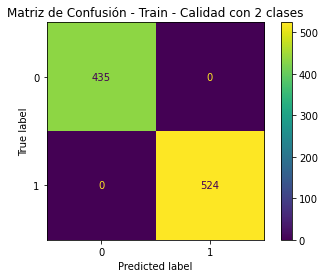

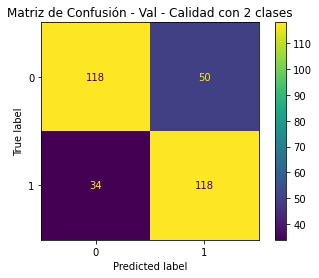

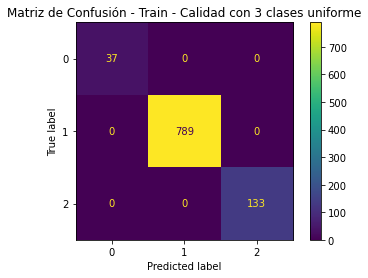

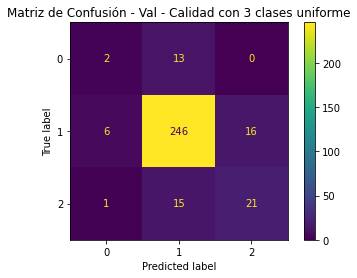

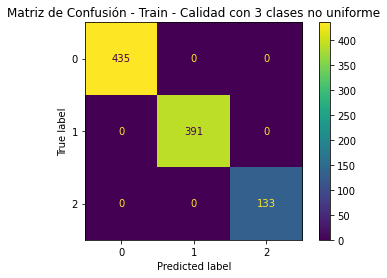

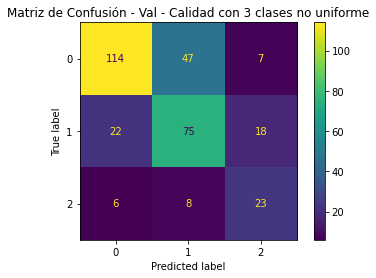

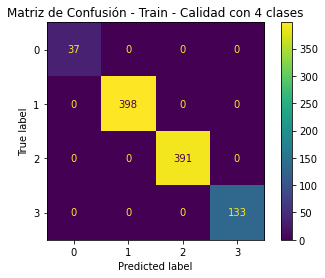

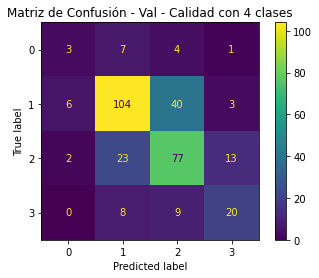

Wall time: 14.6 s


In [17]:
%%time
list_ada = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    search_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()),
                          param_grid={'n_estimators': range(1, 50, 3)},
                          scoring='f1_macro')
    search_ada.fit(X_train, y_train)
    search_ada.best_params_
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(search_ada, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(search_ada, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_ada.append([Y[0], 
                   f1_score(y_train, search_ada.predict(X_train), average='macro'),
                   f1_score(y_val, search_ada.predict(X_val), average='macro'),
                    accuracy_score(y_train, search_ada.predict(X_train)),
                   accuracy_score(y_test, search_ada.predict(X_val)),
                   f1_score(y_train, search_ada.predict(X_train), average=None),
                   f1_score(y_test, search_ada.predict(X_val), average=None)]
                   )

In [18]:
df_metrics_ada = pd.DataFrame(list_ada, columns=labels_metrics)
df_metrics_ada

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,1.0000,0.3718,1.0000,0.3344,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.37209302325581395, 0.40926640926640917, 0.13333333333333333, 0.0]"
1,Calidad con 2 clases,1.0000,0.7375,1.0000,0.5031,"[1.0, 1.0]","[0.45733788395904434, 0.5417867435158502]"
2,Calidad con 3 clases uniforme,1.0000,0.5473,1.0000,0.7031,"[1.0, 1.0, 1.0]","[0.0, 0.8283582089552239, 0.07142857142857144]"
3,Calidad con 3 clases no uniforme,1.0000,0.6296,1.0000,0.3500,"[1.0, 1.0, 1.0]","[0.40989399293286216, 0.38167938931297707, 0.08421052631578947]"
4,Calidad con 4 clases,1.0000,0.5262,1.0000,0.3563,"[1.0, 1.0, 1.0, 1.0]","[0.18181818181818182, 0.4411764705882353, 0.37404580152671757, 0.07142857142857144]"


## Gradient Boosting

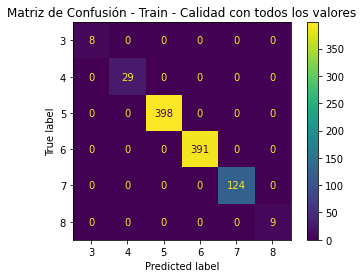

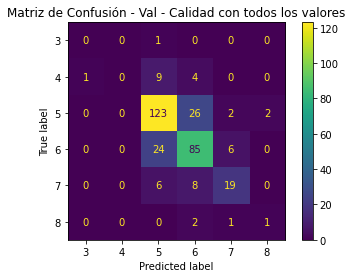

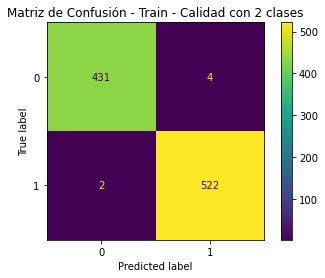

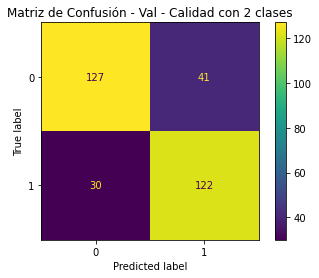

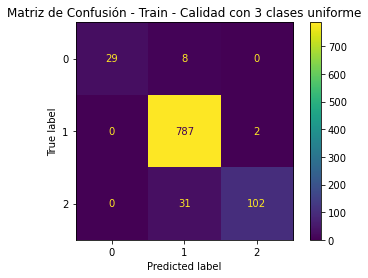

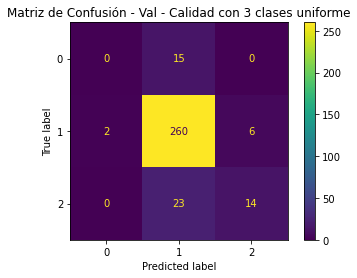

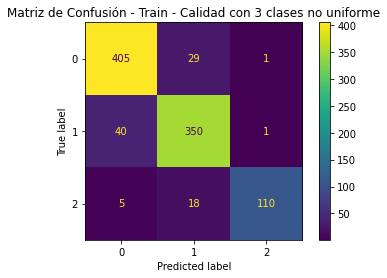

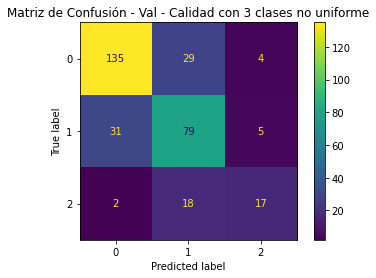

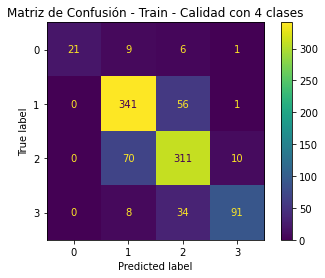

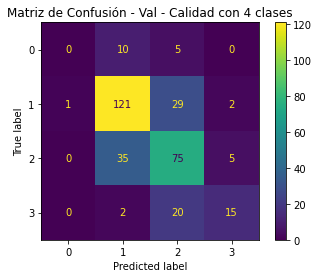

Wall time: 7min 52s


In [19]:
%%time
list_grad = []
for Y in y_list:

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    search_gradient = RandomizedSearchCV(GradientBoostingClassifier(),
                          param_distributions={'n_estimators': range(1, 101, 3), 'max_depth': range(3, 10)},
                          scoring='f1_macro', cv=5)
    search_gradient.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(search_gradient, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_val = "Matriz de Confusión - Val - {}".format(Y[0])
    disp_val = plot_confusion_matrix(search_gradient, X_val, y_val)
    disp_val.ax_.set_title(title_val)
    plt.show()
    list_grad.append([Y[0], 
                   f1_score(y_train, search_gradient.predict(X_train), average='macro'),
                   f1_score(y_val, search_gradient.predict(X_val), average='macro'),
                   accuracy_score(y_train, search_gradient.predict(X_train)),
                   accuracy_score(y_test, search_gradient.predict(X_val)),
                   f1_score(y_train, search_gradient.predict(X_train), average=None),
                   f1_score(y_test, search_gradient.predict(X_val), average=None)]
                   )

In [20]:
df_metrics_grad = pd.DataFrame(list_grad, columns=labels_metrics)
df_metrics_grad

,Variables,F1 Score Train,F1 Score Val,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Validation Scores for each class
0,Calidad con todos los valores,1.0000,0.3992,1.0000,0.3469,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.42320819112627983, 0.3657587548638132, 0.057142857142857134, 0.0]"
1,Calidad con 2 clases,0.9937,0.7781,0.9937,0.4500,"[0.9930875576036866, 0.9942857142857143]","[0.4093959731543625, 0.4853801169590643]"
2,Calidad con 3 clases uniforme,0.9047,0.4700,0.9572,0.7531,"[0.8787878787878788, 0.9746130030959753, 0.8607594936708861]","[0.0, 0.8607142857142857, 0.0]"
3,Calidad con 3 clases no uniforme,0.9005,0.6663,0.9020,0.3875,"[0.9152542372881356, 0.8883248730964467, 0.8979591836734694]","[0.46601941747572817, 0.38759689922480617, 0.0547945205479452]"
4,Calidad con 4 clases,0.7751,0.4693,0.7967,0.3656,"[0.7241379310344828, 0.8256658595641647, 0.7794486215538847, 0.7711864406779663]","[0.0, 0.4429530201342282, 0.3831417624521073, 0.02898550724637681]"


# Mejores Modelos - con datos de entrenamiento y test
Para los modelos de mejor desempeño se hallaron los mejores hiperparámetros, con el fin de probarlos con la sumatoria de los datos de entrenamiento y datos de validación (80%) y con los datos de prueba (20%) que hasta el momento no se habían utilizado.

## Máquina de Soporte Vecotrial (SVM)

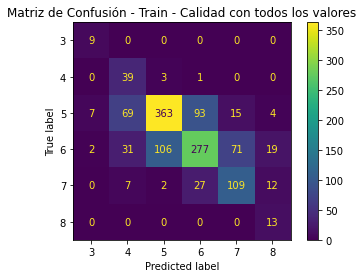

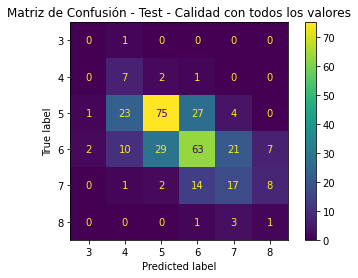

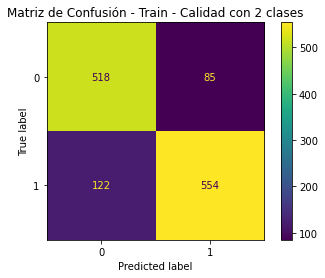

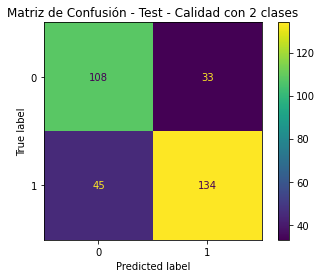

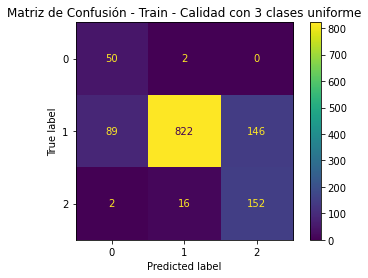

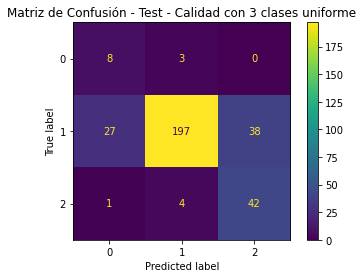

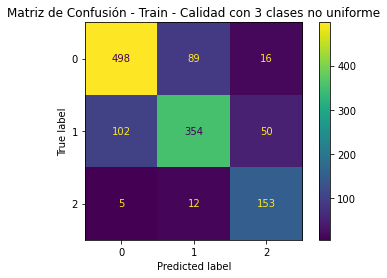

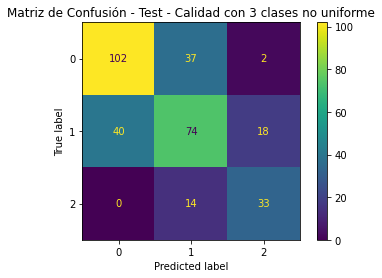

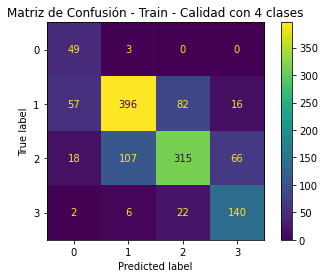

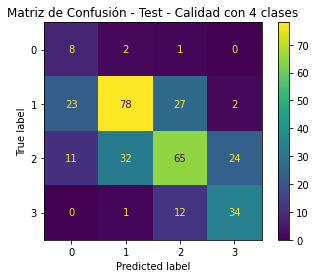

Wall time: 16.3 s


In [21]:
%%time
list_best_svm = []
for Y, param in zip(y_list, best_params_svm):

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    
    best_svm = SVC(kernel='rbf', class_weight='balanced', C=param[1], gamma=param[2])

    best_svm.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(best_svm, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_test = "Matriz de Confusión - Test - {}".format(Y[0])
    disp_test = plot_confusion_matrix(best_svm, X_test, y_test)
    disp_test.ax_.set_title(title_test)
    plt.show()
    list_best_svm.append([Y[0], 
                   f1_score(y_train, best_svm.predict(X_train), average='macro'),
                   f1_score(y_test, best_svm.predict(X_test), average='macro'),
                   accuracy_score(y_train, best_svm.predict(X_train)),
                   accuracy_score(y_test, best_svm.predict(X_test)),
                   f1_score(y_train, best_svm.predict(X_train), average=None),
                   f1_score(y_test, best_svm.predict(X_test), average=None)]
                   )

In [22]:
labels_metrics_test = ['Variables', 'F1 Score Train', 'F1 Score Test','Accuracy Train','Accuracy Test','F1 Train Scores for each class', 'F1 Test Scores for each class']
df_metrics_best_svm = pd.DataFrame(list_best_svm, columns=labels_metrics_test)
df_metrics_best_svm

,Variables,F1 Score Train,F1 Score Test,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.5743,0.3192,0.6333,0.5094,"[0.6666666666666666, 0.4126984126984127, 0.7082926829268291, 0.6128318584070797, 0.6193181818181...","[0.0, 0.2692307692307692, 0.6302521008403361, 0.5294117647058824, 0.39080459770114945, 0.0952380..."
1,Calidad con 2 clases,0.8380,0.7546,0.8382,0.7562,"[0.833467417538214, 0.8425855513307984]","[0.7346938775510204, 0.7745664739884393]"
2,Calidad con 3 clases uniforme,0.6781,0.6158,0.8006,0.7719,"[0.5181347150259068, 0.8666315234580918, 0.6495726495726496]","[0.3404255319148936, 0.8454935622317596, 0.6614173228346456]"
3,Calidad con 3 clases no uniforme,0.7826,0.6522,0.7858,0.6531,"[0.8245033112582781, 0.736732570239334, 0.7866323907455013]","[0.7208480565371025, 0.5758754863813229, 0.66]"
4,Calidad con 4 clases,0.6727,0.5320,0.7037,0.5781,"[0.550561797752809, 0.7450611476952023, 0.6810810810810811, 0.7142857142857143]","[0.3018867924528302, 0.6419753086419754, 0.5485232067510548, 0.6355140186915887]"


## Random Forest

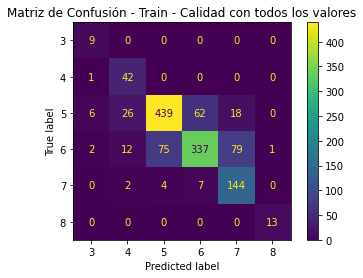

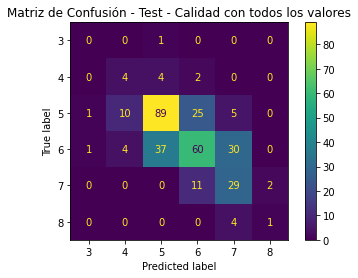

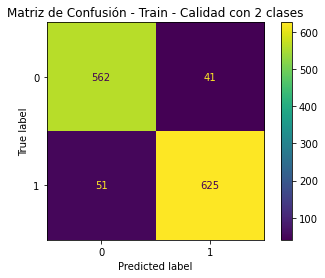

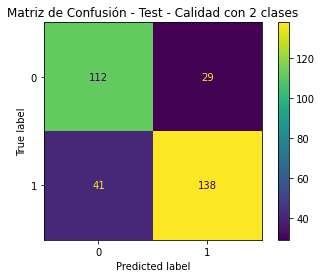

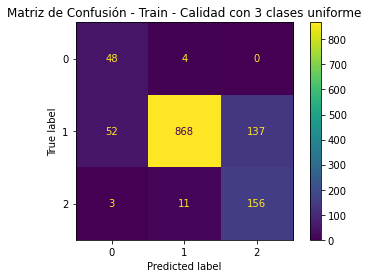

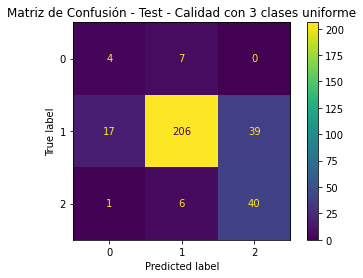

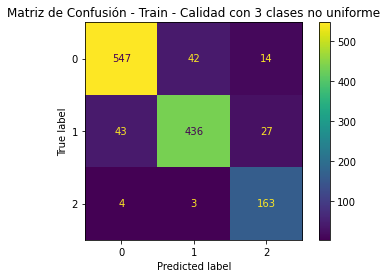

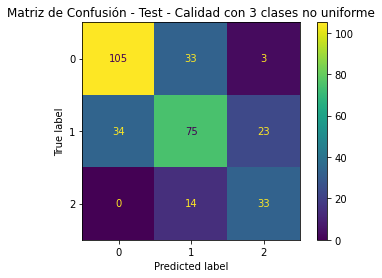

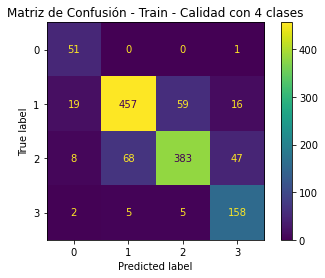

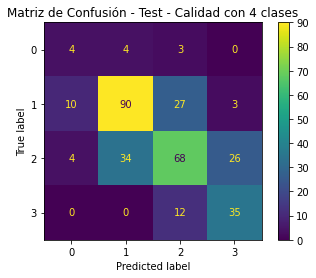

Wall time: 9.22 s


In [23]:
%%time
list_best_forest = []
for Y, params in zip(y_list, best_params_forest):

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    
    best_forest = RandomForestClassifier(class_weight='balanced', max_depth=params[1], min_samples_leaf=params[2], n_estimators=params[3])

    best_forest.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(best_forest, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_test = "Matriz de Confusión - Test - {}".format(Y[0])
    disp_test = plot_confusion_matrix(best_forest, X_test, y_test)
    disp_test.ax_.set_title(title_test)
    plt.show()
    list_best_forest.append([Y[0], 
                   f1_score(y_train, best_forest.predict(X_train), average='macro'),
                   f1_score(y_test, best_forest.predict(X_test), average='macro'),
                   accuracy_score(y_train, best_forest.predict(X_train)),
                   accuracy_score(y_test, best_forest.predict(X_test)),
                   f1_score(y_train, best_forest.predict(X_train), average=None),
                   f1_score(y_test, best_forest.predict(X_test), average=None)]
                   )

In [24]:
df_metrics_best_forest = pd.DataFrame(list_best_forest, columns=labels_metrics_test)
df_metrics_best_forest

,Variables,F1 Score Train,F1 Score Test,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.7643,0.3778,0.7694,0.5719,"[0.6666666666666666, 0.672, 0.8213283442469598, 0.7390350877192983, 0.7236180904522613, 0.962962...","[0.0, 0.2857142857142857, 0.681992337164751, 0.5217391304347826, 0.5272727272727272, 0.25]"
1,Calidad con 2 clases,0.9279,0.7798,0.9281,0.7812,"[0.9243421052631577, 0.9314456035767511]","[0.761904761904762, 0.7976878612716763]"
2,Calidad con 3 clases uniforme,0.7294,0.5780,0.8382,0.7812,"[0.6193548387096774, 0.8948453608247423, 0.6738660907127431]","[0.24242424242424246, 0.8565488565488566, 0.634920634920635]"
3,Calidad con 3 clases no uniforme,0.8897,0.6544,0.8960,0.6656,"[0.9139515455304928, 0.8834853090172239, 0.8716577540106952]","[0.75, 0.5905511811023622, 0.6226415094339622]"
4,Calidad con 4 clases,0.8070,0.5415,0.8202,0.6156,"[0.7727272727272727, 0.8455134135060128, 0.8037775445960126, 0.8061224489795918]","[0.27586206896551724, 0.6976744186046512, 0.5619834710743802, 0.6306306306306305]"


## Bagging Máquina de soporte vectorial (SVM)

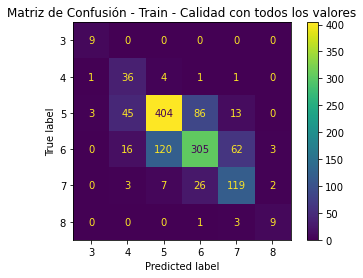

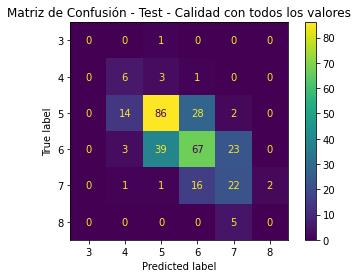

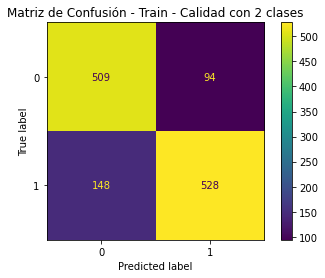

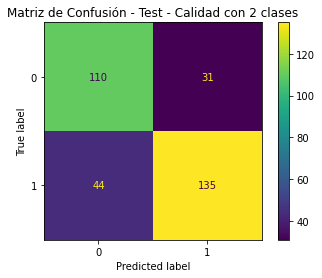

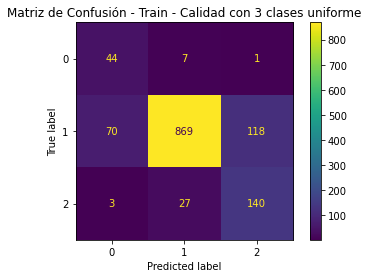

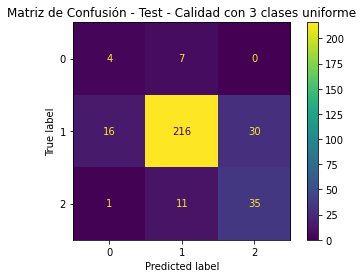

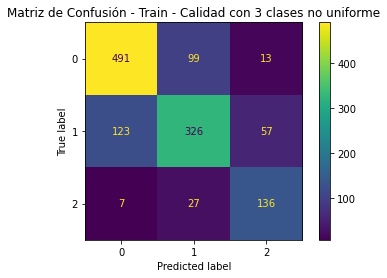

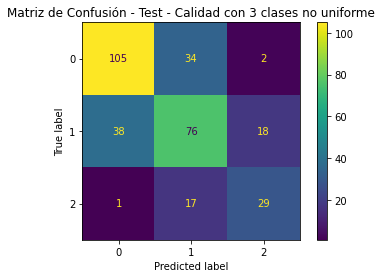

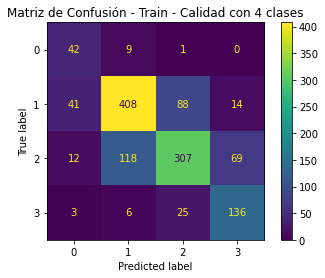

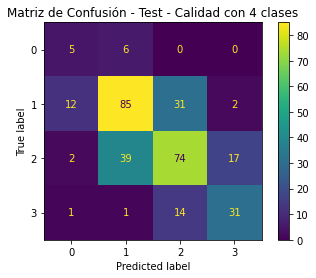

Wall time: 3min 10s


In [37]:
%%time
list_svm_bag = []
for Y, params in zip(y_list, best_params_bag):

    X_train, X_test, y_train, y_test = train_test_split(X, Y[1], test_size=0.2, random_state=42)
    
    best_svm_bag = BaggingClassifier(base_estimator=SVC(kernel='rbf', C=10, gamma=0.05, class_weight='balanced'), n_estimators=params[1], max_samples=2/3)

    best_svm_bag.fit(X_train, y_train)
    title_train = "Matriz de Confusión - Train - {}".format(Y[0])
    disp_train = plot_confusion_matrix(best_svm_bag, X_train, y_train)
    disp_train.ax_.set_title(title_train)
    plt.show()
    title_test = "Matriz de Confusión - Test - {}".format(Y[0])
    disp_test = plot_confusion_matrix(best_svm_bag, X_test, y_test)
    disp_test.ax_.set_title(title_test)
    plt.show()
    list_svm_bag.append([Y[0], 
                   f1_score(y_train, best_svm_bag.predict(X_train), average='macro'),
                   f1_score(y_test, best_svm_bag.predict(X_test), average='macro'),
                   accuracy_score(y_train, best_svm_bag.predict(X_train)),
                   accuracy_score(y_test, best_svm_bag.predict(X_test)),
                   f1_score(y_train, best_svm_bag.predict(X_train), average=None),
                   f1_score(y_test, best_svm_bag.predict(X_test), average=None)]
                   )


In [38]:
df_metrics_best_bagg = pd.DataFrame(list_svm_bag, columns=labels_metrics_test)
df_metrics_best_bagg

,Variables,F1 Score Train,F1 Score Test,Accuracy Train,Accuracy Test,F1 Train Scores for each class,F1 Test Scores for each class
0,Calidad con todos los valores,0.6770,0.3386,0.6896,0.5656,"[0.8181818181818181, 0.5034965034965035, 0.7440147329650092, 0.6594594594594595, 0.6704225352112...","[0.0, 0.35294117647058826, 0.6615384615384615, 0.5491803278688524, 0.4680851063829788, 0.0]"
1,Calidad con 2 clases,0.8107,0.7642,0.8108,0.7656,"[0.807936507936508, 0.8135593220338982]","[0.7457627118644068, 0.782608695652174]"
2,Calidad con 3 clases uniforme,0.6867,0.5820,0.8233,0.7969,"[0.5207100591715976, 0.886734693877551, 0.6526806526806527]","[0.25, 0.870967741935484, 0.625]"
3,Calidad con 3 clases no uniforme,0.7354,0.6426,0.7451,0.6562,"[0.8022875816993463, 0.6805845511482256, 0.723404255319149]","[0.7368421052631579, 0.5868725868725868, 0.6041666666666666]"
4,Calidad con 4 clases,0.6672,0.5507,0.6982,0.6094,"[0.5599999999999999, 0.7472527472527473, 0.6623516720604099, 0.699228791773779]","[0.3225806451612903, 0.6513409961685823, 0.5896414342629481, 0.6391752577319586]"
